Miniprojekt 2: Klassifikation
=

---

Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

Im Jahr 1912 kollidierte die RMS Titanic auf ihrer Jungfernfahrt mit einem Eisberg und sank, wodurch die meisten der Passagiere und der Crew starben. In diesem Miniprojekt untersuchen wir die Passagierdaten auf Hinweise, die das Überleben oder den Tod der Passagiere vorhersagen können.

Setup und Daten
=

In [168]:
# install required packages specified in pipfile
!pipenv install

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.


Installing dependencies from Pipfile.lock (516626)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [169]:
# the usual imports
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

Wir laden die Daten von https://homl.info/titanic.tgz herunter und entpacken sie. Dadurch erhalten wir zwei CSV-Dateien: _train.csv_ und _test.csv_, die wir mit `pandas.read_csv()` laden können. Das Ziel ist es, einen Klassifikator zu trainieren, der die Spalte `Survived` vorhersagen kann auf Basis der anderen Spalten.

(Die Datei _test.csv_ beinhaltet keine Labels, um als Basis für Wettbewerbe dienen zu können. Wir verwenden sie daher hier nicht, sondern führen weiter unten unseren eigenen Train-Test-Split durch, da wir Labels zur Evaluierung benötigen.) 

In [170]:
# import the data - never mind the details
from pathlib import Path
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv"))

train_data = load_titanic_data() 

Aufgabe 1: Datensatz untersuchen
=

Wir untersuchen als erstes den Datensatz `train_data`, um zu verstehen, mit welchen Daten wir es zu tun haben.

**TODO:** 1a) Um welches Datenformat handelt es sich bei `train_data`? Beschreiben Sie im Textfeld kurz, wie man sich dieses Datenformat anschaulich vorstellen kann und was der Unterschied zu einem zweidimensionalen Numpy Array ist. **(2 Punkte)**

type of train data:  <class 'pandas.core.frame.DataFrame'>
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William He

<BarContainer object of 2 artists>

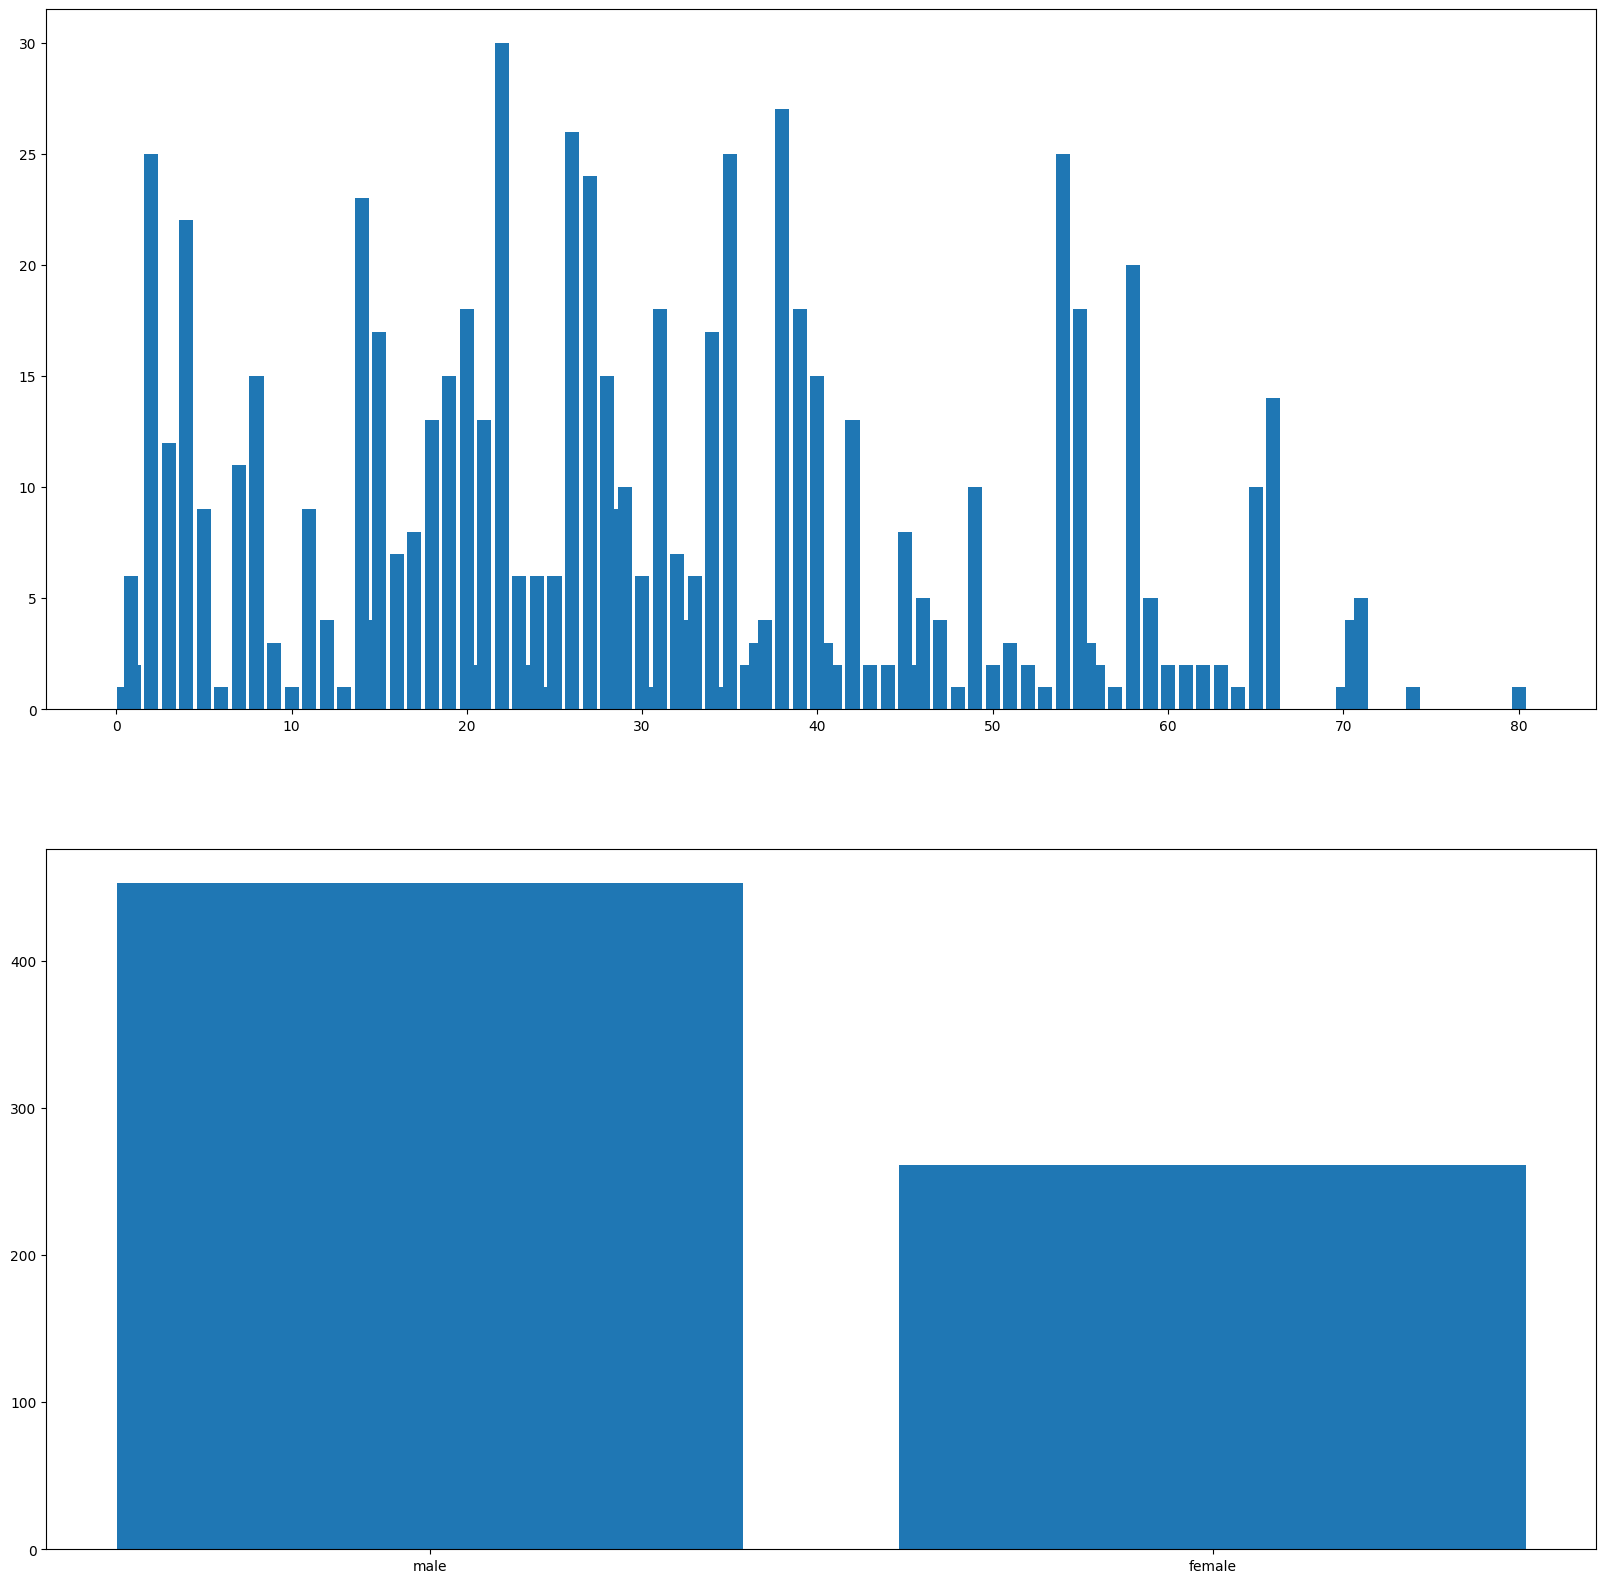

In [171]:
###### TODO: HIER BITTE CODE EINGEBEN #####

cleaned_train_data = train_data.dropna(subset=["Age", "Sex"])

print("type of train data: ", type(train_data))
print(train_data.dtypes)
print(train_data.head())

train_data["Age"].unique()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,20))
ax1.bar(cleaned_train_data["Age"].unique(), cleaned_train_data["Age"].value_counts())
ax2.bar(cleaned_train_data["Sex"].unique(), cleaned_train_data["Sex"].value_counts())



**ANTWORT:** Data format is pandas dataframe. It is more readable and usable for operations. We can visualize the data with different plots for example I plotted the ages and how many people are there that age and what is the number of male and female people. I use bar chart however there are scatter, pie and more charts. Pandas dataframe more useful than numpy arrays while data analyzing. You can use brackets or other keywords to find categories or reach the data.

**TODO**: 1b) Geben Sie die ersten 10 Zeilen von `train_data` aus, um einen Überblick über die Daten zu bekommen! **(1 Punkt)**

In [172]:
###### TODO: HIER BITTE CODE EINGEBEN #####
print(train_data[:10])


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

Die Attribute haben die folgende Bedeutung:
* **PassengerId**: eine eindeutige ID für jeden Passagier
* **Survived**: das ist unser Label: 0 bedeutet der Passagier hat nicht überlebt, 1 bedeutet er hat überlebt.
* **Pclass**: Passagierklasse
* **Name**, **Sex**, **Age**: Name, Geschlecht, Alter
* **SibSp**: wie viele Verwandte ("siblings & spouses") des Passagiers an Bord waren
* **Parch**: wie viele Kinder und Eltern des Passagiers an Bord waren
* **Ticket**: Ticket ID
* **Fare**: bezahlter Preis (in Pfund)
* **Cabin**: Kabinennummer des Passagiers
* **Embarked**: wo der Passagier an Bord gegangen ist

Unser Ziel ist es vorherzusagen, ob ein Passagier überlebt hat, auf Grundlage von Attributen wie seinem Alter, Geschlecht, Passagierklasse, wo er an Bord gegangen ist etc.

Setzen wir explizit das Attribut `PassengerId` als Indexspalte:

In [173]:
# set unique identifier
train_data = train_data.set_index("PassengerId")

**TODO**: 1c) Plotten Sie ein Histogramm, um einen besseren Überblick über die Daten zu bekommen! **(1 Punkt)**

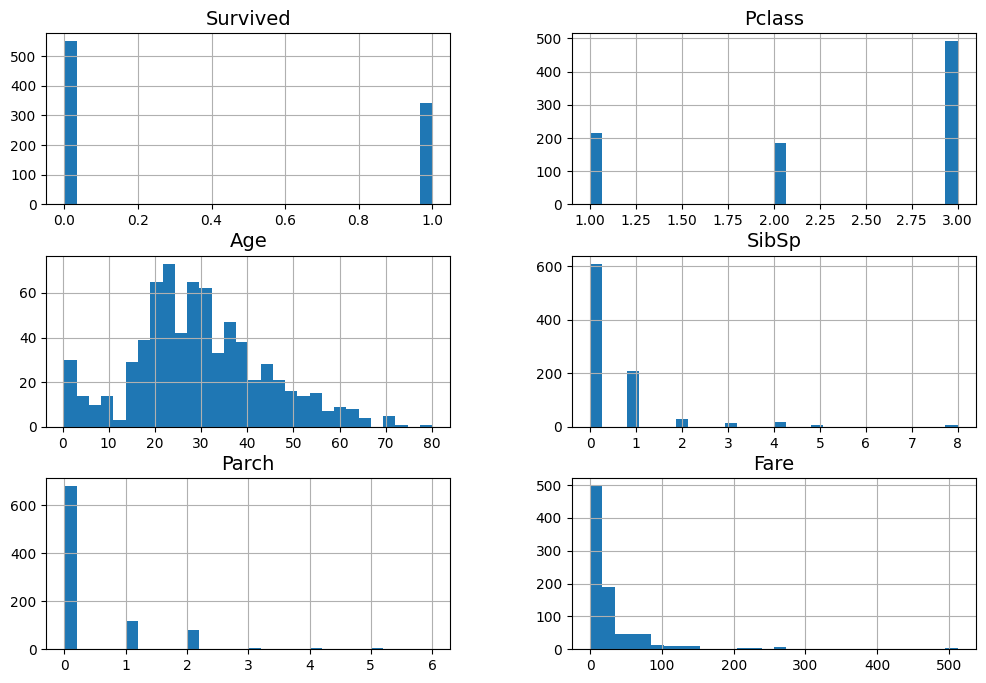

In [174]:
##### TODO: HIER BITTE CODE EINGEBEN #####
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_data.hist(bins=30, figsize=(12, 8))
plt.show()

Wir zeichnen einen Scatterplot, um mögliche Korrelationen zwischen Alter, Ticketpreis und Überlebenswahrscheinlichkeit zu finden. Wir markieren die Überlebenden in grün, die Verstorbenen in rot.

<Axes: xlabel='Age', ylabel='Fare'>

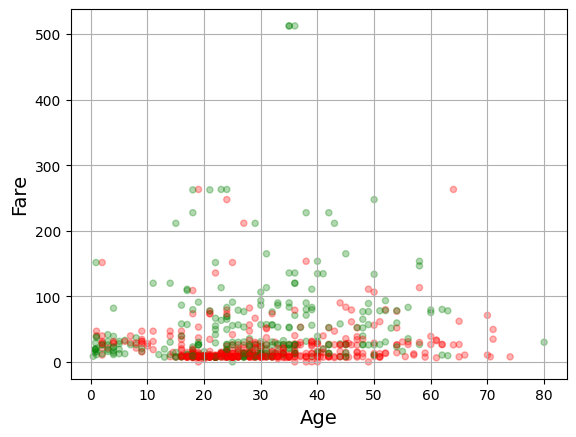

In [175]:
# scatter plot
import matplotlib.colors
train_data.plot(kind="scatter", x="Age", y="Fare", c="Survived", cmap = matplotlib.colors.ListedColormap(['red', 'green']), 
                grid=True, colorbar=False, alpha=0.3)


**TODO**: 1d) Können Sie anhand von Alter oder Ticketpreis eine höhere oder niedrigere Überlebenswahrscheinlichkeit feststellen? Schreiben Sie Ihre Antwort ins Textfeld unten. **(1 Punkt)**

**Antwort**: I think we cannot be sure about the Fare, because we can see all range of Fare there are survived and not survived people. However at age interval I can see the 15-45 interval there are lots of not survived people so this range and lower fare is definetly have higher probability of not surviving.

**TODO:** 1e) Schauen wir uns als nächstes an, wie viele Einträge in den Daten fehlen fehlen (=`null`). Wie viele der Attribute sind (mindestens) lückenhaft? Wie würden Sie mit den lückenhaften Attributen umgehen? Gibt es ggfs. ein Attribut, was Sie komplett entfernen würden? **(2 Punkte)**

In [176]:
###### TODO: HIER BITTE CODE EINGEBEN #####
print("\nBefore Cleaning: \n")
cleaned_train_data = train_data.copy()
print(cleaned_train_data.isnull().sum())

cleaned_train_data = train_data.dropna()
print("\nAfter Cleaning: \n")
print(cleaned_train_data.isnull().sum())



Before Cleaning: 

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

After Cleaning: 

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


**ANTWORT:** we can use isnull to find all nan values and with sum we can see the number of nan values, then using dropna we can get rid all of them.

Die Attribute **Name** und **Ticket** ignorieren wir zunächst, auch wenn sie vielleicht eine gewisse Aussagekraft haben. 

Schauen wir uns die numerischen Attribute genauer an:

In [177]:
# print some statistical infos about data
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**TODO**: 1f) Wie groß wäre die Accuracy eines ganz simplen Modells, das für jeden Passagier vorhersagt, dass er nicht überlebt? **(1 Punkt)**

**Hinweis**: Sie können die Antwort ohne weiteren Code aus dem Output von `train_data.describe()` oben ableiten.

**Antwort**: %61.62 because the mean of the survived people percentage is 0.383838

Jetzt schauen wir uns die kategorischen Attribute genauer an:

In [178]:
# info and numbers of categorical attributes
print(train_data["Pclass"].value_counts(),'\n')

print(train_data["Sex"].value_counts(),'\n')

print(train_data["Embarked"].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64 

Sex
male      577
female    314
Name: count, dtype: int64 

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


Das Attribut **Embarked** sagt aus, an welchem Ort der Passagier an Bord gegangen ist: C=Cherbourg, Q=Queenstown, S=Southampton.

Aufgabe 2: Datenvorverarbeitung
=

Als nächstes bauen wir unsere Preprocessing-Pipelines auf.

**TODO**: 2a) Implementieren Sie die Pipeline für die numerischen Attribute. Verwenden Sie einen `Imputer`, um leere Daten z.B. mit dem Median aufzufüllen, und eine Skalierung. Importieren Sie zuerst die benötigten Pakete. **(2 Punkte)**

In [179]:
###### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

Jetzt können wir die Pipeline für die kategorischen Attribute definieren:

In [180]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

cat_pipeline

Pipeline(steps=[('ordinal_encoder', OrdinalEncoder()),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder', OneHotEncoder(sparse_output=False))])

**TODO**: 2b) Erklären Sie kurz die drei Schritte, die `cat_pipeline` in der Zelle oben durchführt! **(3 Punkte)**


**ANTWORT:** Firstly with OrdinalEncoder categorical values changed to numerical values for example if we have (red, green, blue) red -> 0, green -> 1, blue -> 2. With simple imputer we can fill missing values and the most frequent strategy widely used for categorical attributes. One hot encoder is decreases the categorical values just 0 and 1 for example at the start we say red -> 0, green -> 1, blue -> 2 after one hot encoder there are 3 new columns and they corresponded to red green and blue for example for red values red coluns is 1 and others 0.


Zuletzt kombinieren wir die numerischen und kategorischen Pipelines:

**TODO**: 2c) Implementieren Sie die komplette Preprocessing-Pipeline als `ColumnTransformer()` für numerische und kategorische Attribute gleichzeitig. Verwenden Sie die numerischen Attribute "Age", "SibSp", "Parch", "Fare" und die kategorischen Attribute "Pclass", "Sex", "Embarked". **(2 Punkte)**

In [181]:
##### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]


preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

Super, wir haben eine Preprocessing-Pipeline implementiert, die die Rohdaten als Input bekommt und numerische Features zurückgibt, die wir dann in ein beliebiges ML-Modell füttern können!

**TODO**: 2d) Wenden Sie die oben definierte Pipeline auf die Trainingsdaten an, speichern Sie das Ergebnis in `X` und geben Sie das Ergebnis aus **(2 Punkte)**



In [182]:
##### TODO: HIER BITTE CODE EINGEBEN #####
prepared = preprocessing.fit_transform(train_data)

prepared

array([[-5.92479863e-01,  4.32793366e-01, -4.73673609e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 6.38788956e-01,  4.32793366e-01, -4.73673609e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.84662658e-01, -4.74545196e-01, -4.73673609e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 2.73396598e-16,  4.32793366e-01,  2.00893337e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.84662658e-01, -4.74545196e-01, -4.73673609e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.77063149e-01, -4.74545196e-01, -4.73673609e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

Wir speichern außerdem die Labels in y:

In [183]:
# save labels
y = train_data["Survived"]

**TODO**: 2e) Spalten Sie die Features und Labels in 90% Trainingsdaten und 10% Testdaten auf. Speichern Sie die Daten in `X_train`, `X_test`, `y_train` und `y_test`. Wozu benötigen Sie hier `random_state`? **(2 Punkte)**


In [184]:
###### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(prepared, y, test_size=0.1, random_state=42)

**Antwort:** Random state is a seed, with this specific seed everytime we get same results

**TODO**: 2f) Untersuchen Sie die Datenstruktur von `X_train`. Warum hat das Array 12 Einträge in der zweiten Dimension? Erklären Sie! **(1 Punkt)**

**Hinweis:** Mit `get_feature_names_out()` können Sie die Namen der Features nach der Transformation herausfinden.

In [185]:
###### TODO: HIER BITTE CODE EINGEBEN (OPTIONAL) #####
print(X_train.shape)
print(preprocessing.get_feature_names_out())


(801, 12)
['num__Age' 'num__SibSp' 'num__Parch' 'num__Fare' 'cat__Pclass_0.0'
 'cat__Pclass_1.0' 'cat__Pclass_2.0' 'cat__Sex_0.0' 'cat__Sex_1.0'
 'cat__Embarked_0.0' 'cat__Embarked_1.0' 'cat__Embarked_2.0']


**Antwort**: Because we choose 3 numerical and 4 categorical attributes and we are looking for all combinations which is 3*4 = 12

Aufgabe 3: Klassifikator trainieren und evaluieren
=


Jetzt können wir einen Klassifikator trainieren, der für jede Person vorhersagt, ob sie überlebt oder nicht.

**TODO**: 3a) Legen Sie einen Entscheidungsbaum an. Trainieren Sie den Entscheidungsbaum auf den Trainingsdaten. Benennen Sie den Entscheidungsbaum `tree_clf`. **(2 Punkte)**

**Hinweis**: Wir haben in der Vorlesung bereits gesehen, wie man einen Entscheidungsbaum auf ein Regressionsproblem fittet. Hier haben wir ein Klassifikationsproblem, Sie benötigen daher einen `DecisionTreeClassifier()` statt einem `DecisionTreeRegressor()`. Die Verwendung ist sehr ähnlich! Suchen Sie bei Bedarf online nach der sklearn-Dokumentation für `DecisionTreeClassifier()`. Sie benötigen keine besonderen Einstellungen.

**Hinweis 2**: Wir haben die Trainingsdaten bereits transformiert, Sie benötigen hier also keine weitere Pipeline!

In [186]:
##### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**TODO**: 3b) Bevor wir Prädiktionen auf dem Testdatensatz machen (zur Erinnerung, die Testdaten dürfen nur ein einziges Mal ganz am Ende verwendet werden), führen wir eine 10-fache Kreuzvalidierung auf den Trainingsdaten aus. Rufen Sie die entsprechende Funktion aus sklearn auf und geben Sie den Mittelwert der 10 Fehlerwerte aus. **(2 Punkte)**

In [187]:
##### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.model_selection import cross_val_score

score = cross_val_score(tree_clf, X_train, y_train, cv=10)

print(score, "\n")

print(pd.Series(score).describe())

[0.80246914 0.8125     0.7625     0.7        0.8        0.775
 0.7625     0.7375     0.7875     0.8       ] 

count    10.000000
mean      0.773997
std       0.034802
min       0.700000
25%       0.762500
50%       0.781250
75%       0.800000
max       0.812500
dtype: float64


Um das Ergebnis zu verbessern, probieren wir einen `RandomForest` aus. Wie der Name schon sagt, besteht dieser Klassifikator aus verschiedenen "Bäumen" kombiniert zu einem "Wald".

**TODO**: 3c) Fitten Sie einen `RandomForestClassifier()` und nennen Sie ihn `forest_clf`. Konsultieren Sie ggfs. die Online-Dokumentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. Führen Sie dann wie beim Entscheidungsbaum die 10-fache Kreuzvalidierung durch und geben Sie den mittleren Fehler aus. **(4 Punkte)**

**Hinweis:** Ein `RandomForestClassifier()` ist sehr ähnlich zum `RandomForestRegressor()`, den wir in der Vorlesung kennengelernt haben. In der Vorlesung hatten wir den Parameter `scoring="neg_root_mean_squared_error"` gesetzt, diesen können Sie hier weglassen (der RMSE wird für Regression verwendet, nicht für Klassifikation). Sie benötigen wiederum keine Pipeline.

In [188]:
##### TODO: HIER BITTE CODE EINGEBEN #####
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

score = cross_val_score(forest_clf, X_train, y_train, cv=10)

print(score, "\n")

print(pd.Series(score).describe())

[0.80246914 0.825      0.75       0.7625     0.8375     0.8125
 0.775      0.8        0.8125     0.85      ] 

count    10.000000
mean      0.802747
std       0.032155
min       0.750000
25%       0.781250
50%       0.807485
75%       0.821875
max       0.850000
dtype: float64


Schließlich evaluieren wir die Prädiktion auf dem Testdatensatz:

**TODO**: 3d) Berechnen Sie die Prädiktionen auf dem Testdatensatz für den Entscheidungsbaum und den Random Forest Classifier, speichern Sie das Ergebnis in `y_pred_tree` bzw. `y_pred_forest` und geben Sie die Ergebnisse aus. Was sagt das Ergebnis aus? **(2 Punkte)**

In [189]:
##### TODO: HIER BITTE CODE EINGEBEN #####
y_pred_tree = tree_clf.predict(X_test)
y_pred_forest = forest_clf.predict(X_test)

print(y_pred_tree)
print(y_pred_forest)

print("\nNumber of true predictions of decision tree\n")
print(y_test[y_test == y_pred_tree].value_counts())
print("\nNumber of true predictions of random forest\n")
print(y_test[y_test == y_pred_forest].value_counts())



[1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0]
[1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0]

Number of true predictions of decision tree

Survived
0    44
1    26
Name: count, dtype: int64

Number of true predictions of random forest

Survived
0    44
1    30
Name: count, dtype: int64


**Antwort:** Some of the predictions different, so algorithms find different results. Random forest is more successful.

Wir berechnen zum Schluss, wie gut unsere beiden Klassifikationsmodelle prädiziert haben. Dazu berechnen wir die **Accuracy**, die die Anzahl korrekt klassifizierter Samples gemessen an der Gesamtzahl Samples ausgibt:

$
\text{Accuracy} = \frac{\text{\# korrekt klassifizierte Samples}}{\text{\# Samples}}
$

In [190]:
# Accuracy for decision tree
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_tree)

0.7777777777777778

In [191]:
# Accuracy for random forest
accuracy_score(y_test, y_pred_forest)

0.8222222222222222

Wir bekommen auf dem Testdatensatz sogar bessere Ergebnisse als auf dem Trainingsdatensatz! Diese Variabilität ist vermutlich im sehr kleinen Datensatz begründet: Je nachdem, welchen Split man verwendet, kann man sehr unterschiedliche Ergebnisse erhalten. Sie können es ausprobieren, indem Sie das Notebook mit neuem `random_seed` wiederholen.

Um dieses Ergebnis weiter zu verbessern, könnten wir:
- Weitere Modelle vergleichen und Hyperparameter tunen mit Cross Validation und Grid Search.
- Feature Engineering durchführen, zum Beispiel numerische Attribute zu Gruppen clustern. Das Alter scheint zum Beispiel sehr mit der Überlebenswahrscheinlichkeit zusammenzuhängen, daher könnte man verschiedene Altersgruppen clustern.